In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()._asdict()['date']
latest_date

'2017-08-23'

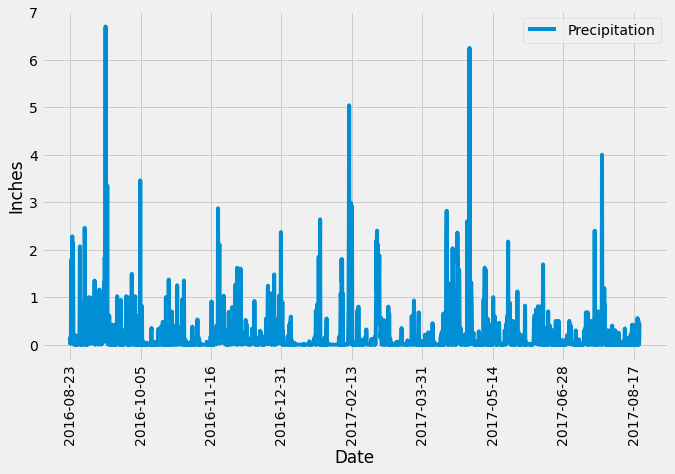

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date_dt = dt.datetime.strptime(latest_date, '%Y-%m-%d')
year_from_last = latest_date_dt - dt.timedelta(days=365)
year_from_last_string = year_from_last.strftime("%Y-%m-%d")
year_from_last_string

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_last_string).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data)
df.columns = ['Date', 'Precipitation']
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylabel='Inches',rot=90, figsize=(10,6))
plt.legend(loc='upper right')
plt.savefig('Images/precip.png');
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
from sqlalchemy import distinct

data = session.query(func.count(distinct(Measurement.station))).scalar()
data

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
from sqlalchemy import text
data = session.query(Measurement.station, func.count(Measurement.station).label('total')).group_by(Measurement.station).order_by(text('total DESC')).all()
data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = data[0][0]
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f'Most active station:{most_active_station}\nLowest temp recorded: {lowest}\nHighest temp recorded: {highest}\nAverage temp recorded: {round(average, 2)}')

Most active station:USC00519281
Lowest temp recorded: 54.0
Highest temp recorded: 85.0
Average temp recorded: 71.66


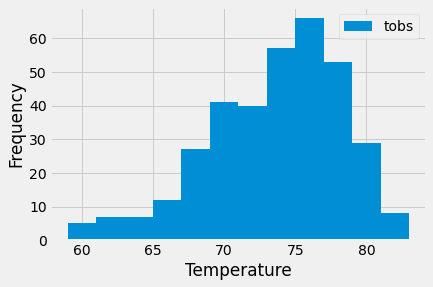

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_from_last_string, Measurement.station == most_active_station).\
    order_by(Measurement.date).all()
df = pd.DataFrame(data)
fig, ax = plt.subplots()
plt.hist(df, 12, label=['tobs'])
plt.title('')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Images/temperature.png')
plt.show()

# Close session

In [39]:
# Close Session
session.close()